<p style='text-align: center'>
  <img src='https://www.researchgate.net/profile/Feng-Xia-7/publication/321952586/figure/fig1/AS:613853171839001@1523365409859/Origin-and-destination-trip-matrix.png' width='500' height=275/><img src='https://ops.fhwa.dot.gov/publications/fhwahop18073/images/figure1.png' width='500' height=275/>
</p>

<div style='text-align:center'>
    <p style='font-family: Helvetica; font-size: 25px; color: rgb(0,125,183);'><strong>Convergence Analysis of Trip Distribution Methods</strong></p>
</div>

# <span style='font-family: Helvetica; font-size: 25px'>**I. Introduction**</span>

<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'>Trip distribution is a critical component of the traditional four-step transportation planning process. It connects the results of trip generation to the spatial interaction between zones, forming a foundational input to mode choice and route assignment. As defined by Ortúzar and Willumsen (2011), <strong>trip distribution "aims to connect the trip productions in each zone with the trip attractions in all other zones, to produce an origin-destination matrix for a given trip purpose" (p. 263).</strong><br><br>This notebook comprehensively explores two major categories of trip distribution techniques: Growth Factor Methods and Synthetic Methods. These approaches aim to allocate trips between origins and destinations based on observed data or functional relationships.<br><br>Growth factor methods utilize known present and future trip productions and attractions for each zone. These methods apply proportional growth and iterate the initial matrix until the generated and attracted totals converge with the forecasted values. In contrast, synthetic methods rely only on the current trip productions and attractions and use cost-based impedance or deterrence functions to estimate trip distributions. The convergence in synthetic methods is evaluated based on how closely the generated or attracted totals match the observed values.<br><br>Each method presented is implemented in a matrix-based form, with graphical illustrations and mathematical walk-throughs to ensure clarity. <strong>The goal is not only to explore their computational logic but also to evaluate their strengths, weaknesses, and convergence behavior under similar conditions.</strong></p>
</div>

# <span style='font-family: Helvetica; font-size: 25px'>**II. Importing libraries**</span>

In [1]:
# General
import warnings

# Fundamental libraries
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, plot, iplot
from plotly.offline import init_notebook_mode
import cufflinks as cf
import plotly.io as pio
from IPython.display import Image

# <span style='font-family: Helvetica; font-size: 25px'>**III. Pre-code set-up**</span>

In [2]:
%load_ext watermark
%watermark -i -v -u -co
init_notebook_mode(connected=True)
%matplotlib inline
cf.go_offline()
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', '{:.4f}'.format)

Last updated: 2025-08-03T16:31:17.397076+08:00

Python implementation: CPython
Python version       : 3.10.18
IPython version      : 8.22.2

conda environment: data_analysis_31013



In [3]:
# px.colors.cyclical.swatches()
# px.colors.qualitative.swatches()
# px.colors.sequential.swatches()

# <span style='font-family: Helvetica; font-size: 25px'>**IV. Trip distribution methods**</span>

## <span style='font-family: Helvetica; font-size: 25px'>**IV.A. Growth factor methods**</span>

<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'><strong>Growth factor methods assume both the present and future trip productions and attractions are known.</strong> The methods distribute future trips by applying scaling factors to a base-year origin-destination (OD) matrix. The scaling factors are derived from the ratio of future to present trip totals for each zone. The process iteratively adjusts trip estimates until the computed totals for each origin and destination zone match the target values within a specified convergence threshold or number of iterations, the latter in this notebook.</p>
</div>

### <span style='font-family: Helvetica; font-size: 25px'>**IV.A.i. Average factor method**</span>

In [4]:
def afm(present_trips, future_trips, growth_rate, afm_iteration):
    
    afm_iteration = afm_iteration
    present_trips = present_trips
    future_trips = future_trips
    growth_rate = growth_rate

    afm_growth_rate = np.zeros((growth_rate.shape[-2] * (afm_iteration + 1), growth_rate.shape[-1]))    # matrix for storing progression of growth rates, adding 1 in iteration to incorporate original data
    afm_array = np.zeros((present_trips.shape[-2] * (afm_iteration + 1), present_trips.shape[-1]))      # matrix for storing progression of present trips, adding 1 in iteration to incorporate original data
    afm_recharging_array = np.zeros((present_trips.shape[-2], present_trips.shape[-1]))     # dedicated mxn matrix to store trips that will be multiplied to averaged growth rate
    afm_recharging_growth_rate = np.zeros_like(afm_recharging_array, dtype=float)       # dedicated mxn matrix to store averaged growth rate

    for i in range(present_trips.shape[-2]):
        for j in range(present_trips.shape[-1]):

            for k in range(growth_rate.shape[-1]):
                afm_growth_rate[i, k] = growth_rate[i, k]       # 0th index (1st level) of trip growth rate matrix
            afm_array[i, j] = present_trips[i, j]       # 0th index (1st level) of present trip matrix


    for t in range(afm_iteration):
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                afm_recharging_growth_rate[i, j] = (afm_growth_rate[(present_trips.shape[-2] * t) + i, 0] +
                                                    afm_growth_rate[(present_trips.shape[-2] * t) + j, 1]) * 0.5  # not advanced
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                afm_recharging_array[i, j] = afm_array[(present_trips.shape[-2] * t) + i, j]  # not advanced             
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                afm_array[(present_trips.shape[-2] * (t + 1)) + i, j] = afm_recharging_array[i, j] * \
                                                                        afm_recharging_growth_rate[i, j]  # advanced, calculating the 1 + nth iteration row of future trips in afm_array
        new_recharging_array_sum = np.transpose(np.vstack(
            (
                afm_array[
                    (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                    0: (present_trips.shape[-1])
                    ].sum(axis=1),
                afm_array[
                    (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                    0: (present_trips.shape[-1])
                    ].sum(axis=0)
            )
        ))        
        new_recharging_growth_rate = future_trips / new_recharging_array_sum        
        for i in range(present_trips.shape[-2]):
            for j in range(growth_rate.shape[-1]):
                afm_growth_rate[(present_trips.shape[-2] * (t + 1)) + i, j] = new_recharging_growth_rate[i, j]  # advanced, calculating the 1 + nth iteration of growth rate in afm_growth_rate
    
    mock_convergence = np.ones((present_trips.shape[-2], afm_growth_rate.shape[-1]), dtype=float)       # base matrix for comparing convergence rate to 1 using 1 + nth iteration growth rate
    
    afm_convergence = afm_growth_rate[
        ((present_trips.shape[-2] * (afm_iteration + 1)) - present_trips.shape[-2]): present_trips.shape[-2] * (afm_iteration + 1),
        0: afm_growth_rate.shape[-1]
        ]
    
    return np.amax(np.absolute(afm_convergence - mock_convergence)) * 100

### <span style='font-family: Helvetica; font-size: 25px'>**IV.A.ii. Detroit method**</span>

In [5]:
def dm(present_trips, future_trips, growth_rate, dm_iteration):
    
    dm_iteration = dm_iteration
    present_trips = present_trips
    future_trips = future_trips
    growth_rate = growth_rate
    dm_growth_rate = np.zeros((growth_rate.shape[-2] * (dm_iteration + 2), growth_rate.shape[-1]))
    dm_array = np.zeros(((dm_iteration + 2) * present_trips.shape[-2], present_trips.shape[-1]))
    dm_recharging_array = np.zeros((present_trips.shape[-2], present_trips.shape[-1]))
    dm_recharging_growth_rate = np.zeros_like(dm_recharging_array, dtype=float)

    for i in range(present_trips.shape[-2]):
        for j in range(present_trips.shape[-1]):
            for k in range(growth_rate.shape[-1]):
                dm_growth_rate[i, k] = growth_rate[i, k]
            dm_array[i, j] = present_trips[i, j]
    
    for t in range(dm_iteration):
        current_recharging_array_sum = dm_array[
            (present_trips.shape[-2] * t): (present_trips.shape[-2] * (t + 1)),
            0 : (present_trips.shape[-1] + 1)
            ].sum(axis=1).sum(axis=0)
        current_total_growth_rate = (future_trips.sum(axis=0)[0])/current_recharging_array_sum
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                dm_recharging_growth_rate[i, j] = (dm_growth_rate[(present_trips.shape[-2] * t) + i, 0] \
                                                   * dm_growth_rate[(present_trips.shape[-2] * t) + j, 1]) \
                                                    * (1/current_total_growth_rate)    # not advanced
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                dm_recharging_array[i, j] = dm_array[(present_trips.shape[-2] * t) + i, j]  # not advanced
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                dm_array[(present_trips.shape[-2] * (t + 1)) + i, j] = dm_recharging_array[i, j] * dm_recharging_growth_rate[i, j]    # advanced
        new_recharging_array_sum = np.transpose(np.vstack(
            (
                dm_array[
                    (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                    0 : (present_trips.shape[-1])
                    ].sum(axis=1),
                dm_array[
                    (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                    0 : (present_trips.shape[-1])
                    ].sum(axis=0)
            )
        ))
        new_recharging_growth_rate = future_trips/new_recharging_array_sum
        for i in range(present_trips.shape[-2]):
            for j in range(growth_rate.shape[-1]):
                dm_growth_rate[(present_trips.shape[-2] * (t + 1)) + i, j] = new_recharging_growth_rate[i, j]    # advanced
    
    mock_convergence = np.ones((present_trips.shape[-2], dm_growth_rate.shape[-1]), dtype=float)
    
    dm_convergence = dm_growth_rate[((present_trips.shape[-2] * (dm_iteration + 1)) - present_trips.shape[-2]):
                                         present_trips.shape[-2] * (dm_iteration + 1), 0: dm_growth_rate.shape[-1]]
    
    return np.amax(np.absolute(dm_convergence - mock_convergence)) * 100

### <span style='font-family: Helvetica; font-size: 25px'>**IV.A.iiI. Fratar method**</span>

In [6]:
def fm(present_trips, future_trips, growth_rate, fm_iteration):

    fm_iteration = fm_iteration
    present_trips = present_trips
    future_trips = future_trips
    growth_rate = growth_rate
    
    fm_growth_rate = np.zeros((growth_rate.shape[-2] * (fm_iteration + 2), growth_rate.shape[-1]))
    fm_array = np.zeros(((fm_iteration + 2) * present_trips.shape[-2], present_trips.shape[-1]))
    fm_recharging_array = np.zeros((present_trips.shape[-2], present_trips.shape[-1]))
    fm_recharging_growth_rate = np.zeros_like(fm_recharging_array, dtype=float)
    fm_trip_growth_rate_divisor = np.zeros_like(present_trips, dtype=float)
    
    for i in range(present_trips.shape[-2]):
        for j in range(present_trips.shape[-1]):
            for k in range(growth_rate.shape[-1]):
                fm_growth_rate[i, k] = growth_rate[i, k]
            fm_array[i, j] = present_trips[i, j]
    
    for t in range((fm_iteration) + 1):
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fm_recharging_array[i, j] = fm_array[(present_trips.shape[-2] * t) + i, j]      # not advanced
        fm_current_growth_rate = fm_growth_rate[
            (present_trips.shape[-2] * t): (present_trips.shape[-2] * (t + 1)),
            0: growth_rate.shape[-1]]       # not advanced
        trips_attraction_growth_rate_sum = np.matmul(fm_recharging_array, fm_current_growth_rate)
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fm_trip_growth_rate_divisor[i, j] = (trips_attraction_growth_rate_sum[:, 1])[i]
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fm_recharging_growth_rate[i, j] = (fm_growth_rate[(present_trips.shape[-2] * t) + i, 0] *      # not advanced
                                                   fm_growth_rate[(present_trips.shape[-2] * t) + j, 1]) * \
                                                  (fm_recharging_array.sum(axis=1)[i]) / fm_trip_growth_rate_divisor[i, 1]
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fm_array[(present_trips.shape[-2] * (t + 1)) + i, j] = fm_recharging_array[i, j] * fm_recharging_growth_rate[i, j]    # advanced
        new_recharging_array_sum = np.transpose(np.vstack(
            (fm_array[
                (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                0 : (present_trips.shape[-1])
                ].sum(axis=1),
            fm_array[
                (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                0 : (present_trips.shape[-1])
                ].sum(axis=0)
            )
        ))
        new_recharging_growth_rate = future_trips/new_recharging_array_sum
        for i in range(present_trips.shape[-2]):
            for j in range(growth_rate.shape[-1]):
                fm_growth_rate[(present_trips.shape[-2] * (t + 1)) + i, j] = new_recharging_growth_rate[i, j]    # advanced
    
    mock_convergence = np.ones((present_trips.shape[-2], fm_growth_rate.shape[-1]), dtype=float)
    
    fm_convergence = fm_growth_rate[
        ((present_trips.shape[-2] * (fm_iteration + 1)) - present_trips.shape[-2]): present_trips.shape[-2] * (fm_iteration + 1),
        0: fm_growth_rate.shape[-1]
    ]
    
    return np.amax(np.absolute(fm_convergence - mock_convergence)) * 100

### <span style='font-family: Helvetica; font-size: 25px'>**IV.A.iv. Furness method**</span>

In [7]:
def fur(present_trips, future_trips, growth_rate, fur_iteration):

    fur_iteration = fur_iteration
    present_trips = present_trips
    future_trips = future_trips
    growth_rate = growth_rate
    
    fur_growth_rate = np.zeros((growth_rate.shape[-2] * (fur_iteration + 2), growth_rate.shape[-1]))
    fur_array = np.zeros(((fur_iteration + 2) * present_trips.shape[-2], present_trips.shape[-1]))
    fur_recharging_array = np.zeros((present_trips.shape[-2], present_trips.shape[-1]))
    fur_recharging_growth_rate = np.zeros_like(fur_recharging_array, dtype=float)
    
    for i in range(present_trips.shape[-2]):
        for j in range(present_trips.shape[-1]):
            for k in range(growth_rate.shape[-1]):
                fur_growth_rate[i, k] = growth_rate[i, k]
            fur_array[i, j] = present_trips[i, j]
    
    for t in range((fur_iteration) + 1):
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fur_recharging_array[i, j] = fur_array[(present_trips.shape[-2] * t) + i, j]      # not advanced
        fur_current_growth_rate = fur_growth_rate[
            (present_trips.shape[-2] * t): (present_trips.shape[-2] * (t + 1)),
            0: growth_rate.shape[-1]]       # not advanced
        if divmod(t, 2)[-1] == 0:
            fur_recharging_growth_rate = fur_current_growth_rate[:, 0]
            for i in range(present_trips.shape[-2]):
                for j in range(present_trips.shape[-1]):
                    fur_array[(present_trips.shape[-2] * (t + 1)) + i, j] = fur_recharging_array[i, j] * fur_recharging_growth_rate[i]      # advanced
        else:
            fur_recharging_growth_rate = fur_current_growth_rate[:, 1]
            for i in range(present_trips.shape[-2]):
                for j in range(present_trips.shape[-1]):
                    fur_array[(present_trips.shape[-2] * (t + 1)) + i, j] = fur_recharging_array[i, j] * fur_recharging_growth_rate[j]      # advanced
        new_recharging_array_sum = np.transpose(np.vstack(
            (fur_array[
                (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                0 : (present_trips.shape[-1])
                ].sum(axis=1),
            fur_array[
                (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                0 : (present_trips.shape[-1])
                ].sum(axis=0)
            )
        ))
        new_recharging_growth_rate = future_trips/new_recharging_array_sum
        for i in range(present_trips.shape[-2]):
            for j in range(growth_rate.shape[-1]):
                fur_growth_rate[(present_trips.shape[-2] * (t + 1)) + i, j] = new_recharging_growth_rate[i, j]    # advanced
    
    mock_convergence = np.ones((present_trips.shape[-2], fur_growth_rate.shape[-1]), dtype=float)
    
    fur_convergence = fur_growth_rate[
        ((present_trips.shape[-2] * (fur_iteration + 1)) - present_trips.shape[-2]): present_trips.shape[-2] * (fur_iteration + 1),
        0: fur_growth_rate.shape[-1]
    ]
    
    return np.amax(np.absolute(fur_convergence - mock_convergence)) * 100

<!-- ## IV.B. **Synthetic** <span style='color:rgb(141,198,63); font-family:Roboto; font-size:20px; align:right; text-decoration: rgb(141,198,63) underline'>**[Methodsg](#III.-Pre-code-set-up)**</span> -->

## <span style='font-family: Helvetica; font-size: 25px'>**IV.B. Synthetic methods**</span>

<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'>Synthetic methods do not require a historical OD matrix. Instead, they rely on present-day productions and attractions, and use a cost or impedance function to estimate trip flows. <strong>The core principle is that trips are more likely to occur between zones with lower travel costs or impedance.</strong> The methods are either generation-constrained, attraction-constrained, or doubly constrained. In this notebook, generation and attraction-constrained approaches were included in the analysis.<br><br>The convergence in synthetic methods is based on the comparison between resulting and observed totals. For generation-constrained methods, the row totals must match the input productions. For attraction-constrained methods, the column totals must match the input attractions.</p>
</div>

### <span style='font-family: Helvetica; font-size: 25px'>**IV.B.i. Gravity method (Impedance function)**</span>

In [8]:
def gm_imp(base_trip_sum, gm_imp_dist, gm_type, gm_iteration):

    gm_iteration = gm_iteration
    base_trip_sum = base_trip_sum
    gm_imp_dist = gm_imp_dist
    
    gm_arr_sum = np.zeros(((gm_iteration + 2) * base_trip_sum.shape[-2], base_trip_sum.shape[-1]))
    gm_trip_imp_prod = np.zeros(((gm_iteration + 2) * gm_imp_dist.shape[-2], gm_imp_dist.shape[-1]))
    gm_recharging_factor = np.zeros_like(gm_trip_imp_prod, dtype=float)
    gm_arr = np.zeros(((gm_iteration + 2) * gm_imp_dist.shape[-2], gm_imp_dist.shape[-1]))
    gm_trip_sum_factor = np.zeros(((gm_iteration + 1) * base_trip_sum.shape[-2], base_trip_sum.shape[-1]))

    for i in range(base_trip_sum.shape[-2]):
        for j in range(base_trip_sum.shape[-1]):
            gm_arr_sum[i, j] = base_trip_sum[i, j]

    if gm_type == 'GEN':
        for i in range(gm_imp_dist.shape[-2]):
            for j in range(gm_imp_dist.shape[-1]):
                gm_trip_imp_prod[j, i] = gm_imp_dist[i, j] * gm_arr_sum[i, 1]
    else:
        for i in range(gm_imp_dist.shape[-2]):
            for j in range(gm_imp_dist.shape[-1]):
                gm_trip_imp_prod[j, i] = gm_imp_dist[i, j] * gm_arr_sum[i, 0]
    
    for t in range((gm_iteration) + 1):
        if gm_type == 'GEN':
            for i in range(gm_imp_dist.shape[-2]):
                for j in range(gm_imp_dist.shape[-1]):
                    gm_recharging_factor[(gm_imp_dist.shape[-2] * t) + i, j] = gm_trip_imp_prod[(gm_imp_dist.shape[-2] * t) + i, j] / gm_trip_imp_prod[(gm_imp_dist.shape[-2] * t) + i, :].sum()
        else:
            for i in range(gm_imp_dist.shape[-2]):
                for j in range(gm_imp_dist.shape[-1]):
                    gm_recharging_factor[(gm_imp_dist.shape[-2] * t) + i, j] = gm_trip_imp_prod[(gm_imp_dist.shape[-2] * t) + i, j] \
                                                                                / gm_trip_imp_prod[(gm_imp_dist.shape[-2] * t) : (gm_imp_dist.shape[-2] * (t + 1)) , j].sum()
        if gm_type == 'GEN':
            for i in range(gm_imp_dist.shape[-2]):
                for j in range(gm_imp_dist.shape[-1]):
                    gm_arr[(gm_imp_dist.shape[-2] * (t + 1)) + i, j] = gm_recharging_factor[(gm_imp_dist.shape[-2] * t) + i, j] *\
                                                                        gm_arr_sum[(gm_imp_dist.shape[-2] * t) + i, 0]
        else:
            for i in range(gm_imp_dist.shape[-2]):
                for j in range(gm_imp_dist.shape[-1]):
                    gm_arr[(gm_imp_dist.shape[-2] * (t + 1)) + i, j] = gm_recharging_factor[(gm_imp_dist.shape[-2] * t) + i, j] *\
                                                                        gm_arr_sum[(gm_imp_dist.shape[-2] * t) + j, 1]
        mock_arr_sum = np.transpose(np.vstack(
            (gm_arr[
                (gm_imp_dist.shape[-2] * (t + 1)): (gm_imp_dist.shape[-2] * (t + 2)),
                0 : (gm_imp_dist.shape[-1])
                ].sum(axis=1),
            gm_arr[
                (gm_imp_dist.shape[-2] * (t + 1)): (gm_imp_dist.shape[-2] * (t + 2)),
                0 : (gm_imp_dist.shape[-1])
                ].sum(axis=0)
            )
        ))        
        for i in range(base_trip_sum.shape[-2]):
            for j in range(base_trip_sum.shape[-1]):
                gm_arr_sum[(base_trip_sum.shape[-2] * (t + 1)) + i, j] = mock_arr_sum[i, j]
        for i in range(base_trip_sum.shape[-2]):
            for j in range(base_trip_sum.shape[-1]):
                gm_trip_sum_factor[(base_trip_sum.shape[-2] * t) + i, j] = gm_arr_sum[(base_trip_sum.shape[-2] * 0) + i, j] / gm_arr_sum[(base_trip_sum.shape[-2] * (t + 1)) + i, j]        # not advanced
        if gm_type == 'GEN':
            for i in range(gm_imp_dist.shape[-2]):
                for j in range(gm_imp_dist.shape[-1]):
                    gm_trip_imp_prod[(gm_imp_dist.shape[-2] * (t + 1)) + i, j] = gm_trip_imp_prod[(gm_imp_dist.shape[-2] * t) + i, j] * gm_trip_sum_factor[(gm_imp_dist.shape[-2] * t) + j, 1]
        else:
            for i in range(gm_imp_dist.shape[-2]):
                for j in range(gm_imp_dist.shape[-1]):
                    gm_trip_imp_prod[(gm_imp_dist.shape[-2] * (t + 1)) + i, j] = gm_trip_imp_prod[(gm_imp_dist.shape[-2] * t) + i, j] * gm_trip_sum_factor[(gm_imp_dist.shape[-2] * t) + i, 0]
                        
    mock_convergence = np.ones((gm_imp_dist.shape[-2], gm_trip_sum_factor.shape[-1]), dtype=float)
    
    gm_imp_convergence = gm_trip_sum_factor[
        ((gm_imp_dist.shape[-2] * gm_iteration) - gm_imp_dist.shape[-2]): gm_imp_dist.shape[-2] * gm_iteration,
        :
    ]
    
    return np.amax(np.absolute(gm_imp_convergence - mock_convergence)) * 100

### <span style='font-family: Helvetica; font-size: 25px'>**IV.B.ii. Gravity method (Deterrence function)**</span>

In [9]:
def gm_det(base_trip_sum, gm_det_cost, gm_type, gm_det_func, gm_iteration, **kwargs):

    gm_iteration = gm_iteration
    base_trip_sum = base_trip_sum
    gm_det_cost = gm_det_cost
    gm_det_beta = kwargs.get('gm_det_beta')
    gm_det_exp = kwargs.get('gm_det_exp')
        
    gm_arr_sum = np.zeros(((gm_iteration + 2) * base_trip_sum.shape[-2], base_trip_sum.shape[-1]))
    gm_trip_imp_prod = np.zeros(((gm_iteration + 2) * gm_det_cost.shape[-2], gm_det_cost.shape[-1]))
    gm_recharging_factor = np.zeros_like(gm_trip_imp_prod, dtype=float)
    gm_arr = np.zeros(((gm_iteration + 2) * gm_det_cost.shape[-2], gm_det_cost.shape[-1]))
    gm_trip_sum_factor = np.zeros(((gm_iteration + 1) * base_trip_sum.shape[-2], base_trip_sum.shape[-1]))

    for i in range(base_trip_sum.shape[-2]):
        for j in range(base_trip_sum.shape[-1]):
            gm_arr_sum[i, j] = base_trip_sum[i, j]

    if gm_type == 'GEN' and gm_det_func == 'Exponential':
        for i in range(gm_det_cost.shape[-2]):
            for j in range(gm_det_cost.shape[-1]):
                gm_trip_imp_prod[j, i] = np.exp(gm_det_beta * gm_det_cost[i, j]) * gm_arr_sum[i, 1]
    elif gm_type == 'ATT' and gm_det_func == 'Exponential':
        for i in range(gm_det_cost.shape[-2]):
            for j in range(gm_det_cost.shape[-1]):
                gm_trip_imp_prod[j, i] = np.exp(gm_det_beta * gm_det_cost[i, j]) * gm_arr_sum[i, 0]
    elif gm_type == 'GEN' and gm_det_func == 'Power':
        for i in range(gm_det_cost.shape[-2]):
            for j in range(gm_det_cost.shape[-1]):
                gm_trip_imp_prod[j, i] = (gm_det_cost[i, j] ** gm_det_exp) * gm_arr_sum[i, 1]
    elif gm_type == 'ATT' and gm_det_func == 'Power':
        for i in range(gm_det_cost.shape[-2]):
            for j in range(gm_det_cost.shape[-1]):
                gm_trip_imp_prod[j, i] = (gm_det_cost[i, j] ** gm_det_exp) * gm_arr_sum[i, 0]
    elif gm_type == 'GEN' and gm_det_func == 'Combined':
        for i in range(gm_det_cost.shape[-2]):
            for j in range(gm_det_cost.shape[-1]):
                gm_trip_imp_prod[j, i] = (gm_det_cost[i, j] ** gm_det_exp) * np.exp(gm_det_beta * gm_det_cost[i, j]) * gm_arr_sum[i, 1]
    elif gm_type == 'ATT' and gm_det_func == 'Combined':
        for i in range(gm_det_cost.shape[-2]):
            for j in range(gm_det_cost.shape[-1]):
                gm_trip_imp_prod[j, i] = (gm_det_cost[i, j] ** gm_det_exp) * np.exp(gm_det_beta * gm_det_cost[i, j]) * gm_arr_sum[i, 0]

    for t in range((gm_iteration) + 1):
        if gm_type == 'GEN':
            for i in range(gm_det_cost.shape[-2]):
                for j in range(gm_det_cost.shape[-1]):
                    gm_recharging_factor[(gm_det_cost.shape[-2] * t) + i, j] = gm_trip_imp_prod[(gm_det_cost.shape[-2] * t) + i, j] / gm_trip_imp_prod[(gm_det_cost.shape[-2] * t) + i, :].sum()
        else:
            for i in range(gm_det_cost.shape[-2]):
                for j in range(gm_det_cost.shape[-1]):
                    gm_recharging_factor[(gm_det_cost.shape[-2] * t) + i, j] = gm_trip_imp_prod[(gm_det_cost.shape[-2] * t) + i, j] \
                                                                                / gm_trip_imp_prod[(gm_det_cost.shape[-2] * t) : (gm_det_cost.shape[-2] * (t + 1)) , j].sum()
        if gm_type == 'GEN':
            for i in range(gm_det_cost.shape[-2]):
                for j in range(gm_det_cost.shape[-1]):
                    gm_arr[(gm_det_cost.shape[-2] * (t + 1)) + i, j] = gm_recharging_factor[(gm_det_cost.shape[-2] * t) + i, j] *\
                                                                        gm_arr_sum[(gm_det_cost.shape[-2] * t) + i, 0]
        else:
            for i in range(gm_det_cost.shape[-2]):
                for j in range(gm_det_cost.shape[-1]):
                    gm_arr[(gm_det_cost.shape[-2] * (t + 1)) + i, j] = gm_recharging_factor[(gm_det_cost.shape[-2] * t) + i, j] *\
                                                                        gm_arr_sum[(gm_det_cost.shape[-2] * t) + j, 1]
        mock_arr_sum = np.transpose(np.vstack(
            (gm_arr[
                (gm_det_cost.shape[-2] * (t + 1)): (gm_det_cost.shape[-2] * (t + 2)),
                0 : (gm_det_cost.shape[-1])
                ].sum(axis=1),
            gm_arr[
                (gm_det_cost.shape[-2] * (t + 1)): (gm_det_cost.shape[-2] * (t + 2)),
                0 : (gm_det_cost.shape[-1])
                ].sum(axis=0)
            )
        ))        
        for i in range(base_trip_sum.shape[-2]):
            for j in range(base_trip_sum.shape[-1]):
                gm_arr_sum[(base_trip_sum.shape[-2] * (t + 1)) + i, j] = mock_arr_sum[i, j]
        for i in range(base_trip_sum.shape[-2]):
            for j in range(base_trip_sum.shape[-1]):
                gm_trip_sum_factor[(base_trip_sum.shape[-2] * t) + i, j] = gm_arr_sum[(base_trip_sum.shape[-2] * 0) + i, j] / gm_arr_sum[(base_trip_sum.shape[-2] * (t + 1)) + i, j]        # not advanced
        if gm_type == 'GEN':
            for i in range(gm_det_cost.shape[-2]):
                for j in range(gm_det_cost.shape[-1]):
                    gm_trip_imp_prod[(gm_det_cost.shape[-2] * (t + 1)) + i, j] = gm_trip_imp_prod[(gm_det_cost.shape[-2] * t) + i, j] * gm_trip_sum_factor[(gm_det_cost.shape[-2] * t) + j, 1]
        else:
            for i in range(gm_det_cost.shape[-2]):
                for j in range(gm_det_cost.shape[-1]):
                    gm_trip_imp_prod[(gm_det_cost.shape[-2] * (t + 1)) + i, j] = gm_trip_imp_prod[(gm_det_cost.shape[-2] * t) + i, j] * gm_trip_sum_factor[(gm_det_cost.shape[-2] * t) + i, 0]
                        
    mock_convergence = np.ones((gm_det_cost.shape[-2], gm_trip_sum_factor.shape[-1]), dtype=float)
    
    gm_imp_convergence = gm_trip_sum_factor[
        ((gm_det_cost.shape[-2] * gm_iteration) - gm_det_cost.shape[-2]): gm_det_cost.shape[-2] * gm_iteration,
        :
    ]
    
    return np.amax(np.absolute(gm_imp_convergence - mock_convergence)) * 100

# <span style='font-family: Helvetica; font-size: 25px'>**V. Convergence testing**</span>

In [10]:
np.random.seed(252)

def ded_test(dist_func, n_zones, n_iter, test_pre_mean, test_pre_var, **kwargs):
    gm_det_beta = kwargs.get('gm_det_beta')
    gm_det_exp = kwargs.get('gm_det_exp')
    arr_present = []
    arr_future = []
    arr_total_present = []
    growth_rate = []
    gm_imp_dist = []
    gm_det_cost = []
    factor_fut_mean = kwargs.get('factor_fut_mean')
    factor_fut_var = kwargs.get('factor_fut_var')
    gm_imp_mean = kwargs.get('gm_imp_mean')
    gm_imp_var = kwargs.get('gm_imp_var')
    gm_type = kwargs.get('gm_type')
    gm_det_func = kwargs.get('gm_det_func')
    gm_det_mean = kwargs.get('gm_det_mean')
    gm_det_var = kwargs.get('gm_det_var')
    
    if (factor_fut_mean != None) and (factor_fut_var != None):
        test_fut_mean = test_pre_mean * (1 + factor_fut_mean)
        test_fut_var = test_pre_var * (1 + factor_fut_var)
    else:
        pass

    for i in n_zones:
        if (gm_imp_mean != None) and (gm_imp_var != None) and (gm_det_func == None):
            mock_imp_dist = np.random.normal(loc=gm_imp_mean, scale=gm_imp_var, size=i**2).astype(int).reshape((i, i))
            gm_imp_dist.append(mock_imp_dist.tolist())
            mock_present = np.random.normal(loc=test_pre_mean, scale=test_pre_var, size=i**2).astype(int).reshape((i, i))
            np.fill_diagonal(mock_present, 0)
            arr_present.append(mock_present.tolist())
            mock_total_present_trips = np.transpose(np.vstack((mock_present.sum(axis=1), mock_present.sum(axis=0))))
            arr_total_present.append(mock_total_present_trips.tolist())
        elif (gm_det_mean != None) and (gm_det_var != None) and (gm_det_func != None):
            mock_det_cost = np.random.normal(loc=gm_det_mean, scale=gm_det_var, size=i**2).astype(int).reshape((i, i))
            gm_det_cost.append(mock_det_cost.tolist())
            mock_present = np.random.normal(loc=test_pre_mean, scale=test_pre_var, size=i**2).astype(int).reshape((i, i))
            np.fill_diagonal(mock_present, 0)
            arr_present.append(mock_present.tolist())
            mock_total_present_trips = np.transpose(np.vstack((mock_present.sum(axis=1), mock_present.sum(axis=0))))
            arr_total_present.append(mock_total_present_trips.tolist())
        else:
            mock_present = np.random.normal(loc=test_pre_mean, scale=test_pre_var, size=i**2).astype(int).reshape((i, i))
            np.fill_diagonal(mock_present, 0)
            mock_future = np.random.normal(loc=test_fut_mean, scale=test_fut_var, size=i*2).astype(int).reshape((i, 2))
            arr_present.append(mock_present.tolist())
            arr_future.append(mock_future.tolist())
            mock_total_present_trips = np.transpose(np.vstack((mock_present.sum(axis=1), mock_present.sum(axis=0))))
            arr_total_present.append(mock_total_present_trips.tolist())
            growth_rate.append(mock_future / mock_total_present_trips)
    
    if dist_func == "AFM":
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = afm(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
    elif dist_func == "DM":
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = dm(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
    elif dist_func == "FM":
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = fm(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
    elif dist_func == "FurM":
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = fur(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
    elif dist_func == "GMImp":
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = gm_imp(np.array(arr_total_present[i]), np.array(gm_imp_dist[i]), gm_type=gm_type, gm_iteration=j + 1)
    elif dist_func == "GMDet" and gm_det_func == 'Exponential':
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = gm_det(np.array(arr_total_present[i]), np.array(gm_det_cost[i]), gm_det_func=gm_det_func,
                                                    gm_det_beta=gm_det_beta, gm_type=gm_type, gm_iteration=j + 1)
    elif dist_func == "GMDet" and gm_det_func == 'Power':
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = gm_det(np.array(arr_total_present[i]), np.array(gm_det_cost[i]), gm_det_func=gm_det_func,
                                                    gm_det_exp=gm_det_exp, gm_type=gm_type, gm_iteration=j + 1)
    elif dist_func == "GMDet" and gm_det_func == 'Combined':
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = gm_det(np.array(arr_total_present[i]), np.array(gm_det_cost[i]), gm_det_func=gm_det_func,
                                                    gm_det_beta=gm_det_beta, gm_det_exp=gm_det_exp, gm_type=gm_type, gm_iteration=j + 1)

    comp_df_method = []
    
    if dist_func == "AFM":
        comp_df_method.append(np.array(['Average Factor Method']* n_iter * len(n_zones)))
    elif dist_func == "DM":
        comp_df_method.append(np.array(['Detroit Method']* n_iter * len(n_zones)))
    elif dist_func == "FM":
        comp_df_method.append(np.array(['Fratar Method']* n_iter * len(n_zones)))
    elif dist_func == "FurM":
        comp_df_method.append(np.array(['Furness Method']* n_iter * len(n_zones)))
    elif dist_func == "GMImp" and gm_type == "ATT":
        comp_df_method.append(np.array(['Gravity Method (Impedance) - Attraction Constrained']* n_iter * len(n_zones)))
    elif dist_func == "GMImp" and gm_type == "GEN":
        comp_df_method.append(np.array(['Gravity Method (Impedance) - Generation Constrained']* n_iter * len(n_zones)))
    elif dist_func == "GMDet" and gm_det_func == 'Exponential':
        comp_df_method.append(np.array(['Gravity Method (Deterrence) - Exponential Cost Function']* n_iter * len(n_zones)))
    elif dist_func == "GMDet" and gm_det_func == 'Power':
        comp_df_method.append(np.array(['Gravity Method (Deterrence) - Power Cost Function']* n_iter * len(n_zones)))
    elif dist_func == "GMDet" and gm_det_func == 'Combined':
        comp_df_method.append(np.array(['Gravity Method (Deterrence) - Combined Cost Function']* n_iter * len(n_zones)))
    
    comp_df_method = np.array(comp_df_method).flatten()
        
    comp_df_zones = []
    
    for i in (n_zones):
        mock = str(i)
        comp_df_zones.append(np.array([mock]*n_iter))
    
    comp_df_zones = np.array(comp_df_zones).flatten()

    comp_df_iter = np.tile(np.arange(start=1, stop=n_iter + 1, step=1), len(n_zones))
    
    comparison_df = pd.DataFrame({
        'Method' : comp_df_method,
        'Number of Zones' : comp_df_zones,
        'Iteration' : comp_df_iter,
        'Convergence' : conv_arr
        }, 
        columns=['Method', 'Number of Zones', 'Iteration', 'Convergence'])
    
    fig = px.line(comparison_df, x='Iteration', y='Convergence', color='Method', 
                line_dash='Number of Zones', labels={'Convergence': 'Convergence (%)'},
                title='Trip Distribution Method Convergence',
                color_discrete_sequence=[px.colors.sequential.Rainbow[3],
                                         px.colors.sequential.Viridis[7],
                                         px.colors.sequential.Viridis[9],])
    
    fig.update_layout(
    xaxis=dict(showgrid=False, showticklabels=True, linecolor='#53868B', linewidth=2, 
               ticks="outside", tickfont=dict(family='Nirmala UI', size=12, color='#00008B')),
    yaxis=dict(showgrid=False, showticklabels=True, linecolor="#53868B", linewidth=2, 
               ticks='outside', tickfont=dict(family='Nirmala UI', size=12, color='#00008B')),
    plot_bgcolor='#F7F7F7', paper_bgcolor= '#F7F7F7', legend_title_text='Method, Number of Zones',
    yaxis_range=[0,25])

    if dist_func == "AFM":
        fig.add_annotation(text=f'Average Factor Method Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Future Trips: Mean Increase = {factor_fut_mean * 100:.0f}%, and Variance Increase = {factor_fut_var * 100:.0f}%',
                                     xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=15),
                                     xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "DM":
        fig.add_annotation(text=f'Detroit Method Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Future Trips: Mean Increase = {factor_fut_mean * 100:.0f}%, and Variance Increase = {factor_fut_var * 100:.0f}%',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "FM":
        fig.add_annotation(text=f'Fratar Method Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Future Trips: Mean Increase = {factor_fut_mean * 100:.0f}%, and Variance Increase = {factor_fut_var * 100:.0f}%',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "FurM":
        fig.add_annotation(text=f'Furness Method Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Future Trips: Mean Increase = {factor_fut_mean * 100:.0f}%, and Variance Increase = {factor_fut_var * 100:.0f}%',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "GMImp" and gm_type == 'ATT':
        fig.add_annotation(text=f'Gravity Method (Impedance) - Attraction Constrained Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Impedance: Mean = {gm_imp_mean}, and Variance = {gm_imp_var}',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "GMImp" and gm_type == 'GEN':
        fig.add_annotation(text=f'Gravity Method (Impedance) - Generation Constrained Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Impedance: Mean = {gm_imp_mean}, and Variance = {gm_imp_var}',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "GMDet" and gm_det_func == 'Exponential' and gm_type == 'ATT':
        fig.add_annotation(text=f'Gravity Method (Deterrence) - Exponential Cost Function & Attraction Constrained Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Impedance: Mean = {gm_det_mean}, Variance = {gm_det_var}, and Beta = {gm_det_beta}',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "GMDet" and gm_det_func == 'Exponential' and gm_type == 'GEN':
        fig.add_annotation(text=f'Gravity Method (Deterrence) - Exponential Cost Function & Generation Constrained Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Impedance: Mean = {gm_det_mean}, Variance = {gm_det_var}, and Beta = {gm_det_beta}',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "GMDet" and gm_det_func == 'Power' and gm_type == 'ATT':
        fig.add_annotation(text=f'Gravity Method (Deterrence) - Power Cost Function & Attraction Constrained Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Impedance: Mean = {gm_det_mean}, Variance = {gm_det_var}, and Exponent = {gm_det_exp}',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "GMDet" and gm_det_func == 'Power' and gm_type == 'GEN':
        fig.add_annotation(text=f'Gravity Method (Deterrence) - Power Cost Function & Generation Constrained Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Impedance: Mean = {gm_det_mean}, Variance = {gm_det_var}, and Exponent = {gm_det_exp}',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "GMDet" and gm_det_func == 'Combined' and gm_type == 'ATT':
        fig.add_annotation(text=f'Gravity Method (Deterrence) - Combined Cost Function & Attraction Constrained Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Impedance: Mean = {gm_det_mean}, Variance = {gm_det_var}, Beta = {gm_det_beta}, and Exponent = {gm_det_exp}',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "GMDet" and gm_det_func == 'Combined' and gm_type == 'GEN':
        fig.add_annotation(text=f'Gravity Method (Deterrence) - Combined Cost Function and Generation Constrained Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Impedance: Mean = {gm_det_mean}, Variance = {gm_det_var}, Beta = {gm_det_beta}, and Exponent = {gm_det_exp}',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)

    fig.show(renderer='png', width=1250, height=450)

In [11]:
np.random.seed(252)

def conv_test(dist_func_arr, n_zones, test_pre_mean, test_pre_var, n_iter,  **kwargs):
    factor_fut_mean = kwargs.get('factor_fut_mean')
    factor_fut_var = kwargs.get('factor_fut_var')
    gm_imp_mean = kwargs.get('gm_imp_mean')
    gm_imp_var = kwargs.get('gm_imp_var')
    gm_det_mean = kwargs.get('gm_det_mean')
    gm_det_var = kwargs.get('gm_det_var')
    gm_det_func = kwargs.get('gm_det_func')
    gm_det_beta = kwargs.get('gm_det_beta')
    gm_det_exp = kwargs.get('gm_det_exp')
    gm_type = kwargs.get('gm_type')
    
    test_fut_mean = test_pre_mean * (1 + factor_fut_mean)
    test_fut_var = test_pre_var * (1 + factor_fut_var)
    arr_present = []
    arr_future = []
    arr_total_present = []
    growth_rate = []
    gm_imp_dist = []
    gm_det_cost = []

    for i in n_zones:
        mock_present = np.random.normal(loc=test_pre_mean, scale=test_pre_var, size=i**2).astype(int).reshape((i, i))
        np.fill_diagonal(mock_present, 0)
        mock_future = np.random.normal(loc=test_fut_mean, scale=test_fut_var, size=i*2).astype(int).reshape((i, 2))
        arr_present.append(mock_present.tolist())
        arr_future.append(mock_future.tolist())
        mock_total_present_trips = np.transpose(np.vstack((mock_present.sum(axis=1), mock_present.sum(axis=0))))
        arr_total_present.append(mock_total_present_trips.tolist())
        
    if ('AFM' in dist_func_arr) | ('DM' in dist_func_arr) | ('FM' in dist_func_arr) | ('FurM' in dist_func_arr):
        for i in n_zones:
            growth_rate.append(mock_future / mock_total_present_trips)
        
    if ('GMImp' in dist_func_arr):
        for i in n_zones:
            mock_imp_dist = np.random.normal(loc=gm_imp_mean, scale=gm_imp_var, size=i**2).astype(int).reshape((i, i))
            gm_imp_dist.append(mock_imp_dist.tolist())

    if ('GMDet' in dist_func_arr):
        for i in n_zones:
            mock_det_cost = np.random.normal(loc=gm_det_mean, scale=gm_det_var, size=i**2).astype(int).reshape((i, i))
            gm_det_cost.append(mock_det_cost.tolist())

    if (gm_type == None) and (gm_det_func == None):
        conv_arr = np.zeros((1, len(dist_func_arr) * n_iter * len(n_zones))).flatten()
        comp_df_method = np.zeros((1, len(dist_func_arr) * n_iter * len(n_zones))).astype('object').flatten()
        comp_df_zones = np.zeros((1, len(dist_func_arr) * n_iter * len(n_zones))).flatten()
        comp_df_iter = np.tile(np.arange(start=1, stop=n_iter + 1, step=1), len(dist_func_arr)*len(n_zones))
        for n_method in range(len(dist_func_arr)):
            if dist_func_arr[n_method] == 'AFM':
                for i in range(len(n_zones)):
                    for j in range(n_iter):
                        conv_arr[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = afm(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
                        comp_df_method[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = 'Average Factor Method'
                        comp_df_zones[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = n_zones[i]
            elif dist_func_arr[n_method] == 'DM':
                for i in range(len(n_zones)):
                    for j in range(n_iter):
                        conv_arr[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = dm(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
                        comp_df_method[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = 'Detroit Method'
                        comp_df_zones[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = n_zones[i]
            elif dist_func_arr[n_method] == 'FM':
                for i in range(len(n_zones)):
                    for j in range(n_iter):
                        conv_arr[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = fm(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
                        comp_df_method[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = 'Fratar Method'
                        comp_df_zones[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = n_zones[i]
            elif dist_func_arr[n_method] == 'FurM':
                for i in range(len(n_zones)):
                    for j in range(n_iter):
                        conv_arr[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = fur(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
                        comp_df_method[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = 'Furness Method'
                        comp_df_zones[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = n_zones[i]

    elif ('GMImp' in dist_func_arr) and ('GMDet' not in dist_func_arr) and (gm_type != None) and (gm_det_func == None):
        conv_arr = np.zeros((1, len(dist_func_arr) * len(gm_type) * n_iter * len(n_zones))).flatten()
        comp_df_method = np.zeros((1, len(dist_func_arr) * len(gm_type) * n_iter * len(n_zones))).astype('object').flatten()
        comp_df_zones = np.zeros((1, len(dist_func_arr) * len(gm_type) * n_iter * len(n_zones))).flatten()
        comp_df_iter = np.tile(np.arange(start=1, stop=n_iter + 1, step=1), len(dist_func_arr) * len(gm_type) * len(n_zones))
        for n_method in range(len(dist_func_arr)):
            for i in range(len(gm_type)):
                if (dist_func_arr[n_method] == 'AFM')  and (i < 1):
                    for j in range(len(n_zones)):
                        for k in range(n_iter):
                            conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = \
                                                                        afm(np.array(arr_present[j]), np.array(arr_future[j]), np.array(growth_rate[j]), k + 1)
                            comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = 'Average Factor Method'
                            comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = n_zones[j]
                elif (dist_func_arr[n_method] == 'AFM') and (i > 0):
                    for j in range(len(n_zones)):
                        for k in range(n_iter):
                            conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                            comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                            comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                elif (dist_func_arr[n_method] == 'DM')  and (i < 1):
                    for j in range(len(n_zones)):
                        for k in range(n_iter):
                            conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = \
                                                                        dm(np.array(arr_present[j]), np.array(arr_future[j]), np.array(growth_rate[j]), k + 1)
                            comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = 'Detroit Method'
                            comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = n_zones[j]
                elif (dist_func_arr[n_method] == 'DM') and (i > 0):
                    for j in range(len(n_zones)):
                        for k in range(n_iter):
                            conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                            comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                            comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                elif (dist_func_arr[n_method] == 'FM')  and (i < 1):
                    for j in range(len(n_zones)):
                        for k in range(n_iter):
                            conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = \
                                                                        fm(np.array(arr_present[j]), np.array(arr_future[j]), np.array(growth_rate[j]), k + 1)
                            comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = 'Fratar Method'
                            comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = n_zones[j]
                elif (dist_func_arr[n_method] == 'FM') and (i > 0):
                    for j in range(len(n_zones)):
                        for k in range(n_iter):
                            conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                            comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                            comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                elif (dist_func_arr[n_method] == 'FurM') and (i < 1):
                    for j in range(len(n_zones)):
                        for k in range(n_iter):
                            conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = \
                                                                        fur(np.array(arr_present[j]), np.array(arr_future[j]), np.array(growth_rate[j]), k + 1)
                            comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = 'Furness Method'
                            comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = n_zones[j]
                elif (dist_func_arr[n_method] == 'FurM') and (i > 0):
                    for j in range(len(n_zones)):
                        for k in range(n_iter):
                            conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                            comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                            comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                elif dist_func_arr[n_method] == 'GMImp':
                    if gm_type[i] == 'GEN':
                        for j in range(len(n_zones)):
                            for k in range(n_iter):
                                conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = \
                                                                            gm_imp(np.array(arr_total_present[j]), np.array(gm_imp_dist[j]), gm_type=type, gm_iteration=k + 1)
                                comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = 'Gravity Method (Impedance) - Generation Constrained'
                                comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = n_zones[j]
                    elif gm_type[i] == 'ATT':
                        for j in range(len(n_zones)):
                            for k in range(n_iter):
                                conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = \
                                                                            gm_imp(np.array(arr_total_present[j]), np.array(gm_imp_dist[j]), gm_type=type, gm_iteration=k + 1)
                                comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = 'Gravity Method (Impedance) - Attraction Constrained'
                                comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = n_zones[j]
                else:
                    pass
    elif ('GMImp' in dist_func_arr) and ('GMDet' in dist_func_arr) and (gm_type != None) and (gm_det_func != None):
        conv_arr = np.zeros((1, len(dist_func_arr) * len(gm_type) * len(gm_det_func) * n_iter * len(n_zones))).flatten()
        comp_df_method = np.zeros((1, len(dist_func_arr) * len(gm_type) * len(gm_det_func) * n_iter * len(n_zones))).astype('object').flatten()
        comp_df_zones = np.zeros((1, len(dist_func_arr) * len(gm_type) * len(gm_det_func) * n_iter * len(n_zones))).flatten()
        comp_df_iter = np.tile(np.arange(start=1, stop=n_iter + 1, step=1), len(dist_func_arr) * len(gm_type) * len(gm_det_func) * len(n_zones))
        for n_method in range(len(dist_func_arr)):
            for i in range(len(gm_det_func)):
                for j in range(len(gm_type)):
                    if (dist_func_arr[n_method] == 'AFM')  and (j < 1):
                        for k in range(len(n_zones)):
                            for l in range(n_iter):
                                conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                afm(np.array(arr_present[k]), np.array(arr_future[k]), np.array(growth_rate[k]), l + 1)
                                comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = 'Average Factor Method'
                                comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                    elif (dist_func_arr[n_method] == 'AFM') and ((i > 0) or (j > 0)):
                        for k in range(len(n_zones)):
                            for l in range(n_iter):
                                conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                    elif (dist_func_arr[n_method] == 'DM')  and (j < 1):
                        for k in range(len(n_zones)):
                            for l in range(n_iter):
                                conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                dm(np.array(arr_present[k]), np.array(arr_future[k]), np.array(growth_rate[k]), l + 1)
                                comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = 'Detroit Method'
                                comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                    elif (dist_func_arr[n_method] == 'DM') and ((i > 0) or (j > 0)):
                        for k in range(len(n_zones)):
                            for l in range(n_iter):
                                conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                    elif (dist_func_arr[n_method] == 'FM')  and (j < 1):
                        for k in range(len(n_zones)):
                            for l in range(n_iter):
                                conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                fm(np.array(arr_present[k]), np.array(arr_future[k]), np.array(growth_rate[k]), l + 1)
                                comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = 'Fratar Method'
                                comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                    elif (dist_func_arr[n_method] == 'FM') and ((i > 0) or (j > 0)):
                        for k in range(len(n_zones)):
                            for l in range(n_iter):
                                conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                    elif (dist_func_arr[n_method] == 'FurM') and (j < 1):
                        for k in range(len(n_zones)):
                            for l in range(n_iter):
                                conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                fur(np.array(arr_present[k]), np.array(arr_future[k]), np.array(growth_rate[k]), l + 1)
                                comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = 'Furness Method'
                                comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                    elif (dist_func_arr[n_method] == 'FurM') and ((i > 0) or (j > 0)):
                        for k in range(len(n_zones)):
                            for l in range(n_iter):
                                conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                    elif dist_func_arr[n_method] == 'GMImp':
                        if gm_type[j] == 'GEN' and (i < 1):
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                    gm_imp(np.array(arr_total_present[k]), np.array(gm_imp_dist[k]), gm_type=type, gm_iteration=l + 1)
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                                                'Gravity Method (Impedance) - Generation Constrained'
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                        elif gm_type[j] == 'GEN' and (i > 0):
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                        elif gm_type[j] == 'ATT' and (i < 1):
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                    gm_imp(np.array(arr_total_present[k]), np.array(gm_imp_dist[k]), gm_type=type, gm_iteration=l + 1)
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                                                'Gravity Method (Impedance) - Attraction Constrained'
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                        elif gm_type[j] == 'ATT' and (i > 0):
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                    elif dist_func_arr[n_method] == 'GMDet':
                        if gm_type[j] == 'GEN' and gm_det_func[i] == 'Exponential':
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                    gm_det(np.array(arr_total_present[k]), np.array(gm_det_cost[k]), gm_det_func=gm_det_func[i],
                                                                                           gm_det_beta=gm_det_beta, gm_type=gm_type[j], gm_iteration=l + 1)
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                                                'Gravity Method (Deterrence) - Exponential Cost Function & Generation Constrained'
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                        elif gm_type[j] == 'ATT' and gm_det_func[i] == 'Exponential':
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                    gm_det(np.array(arr_total_present[k]), np.array(gm_det_cost[k]), gm_det_func=gm_det_func[i],
                                                                                           gm_det_beta=gm_det_beta, gm_type=gm_type[j], gm_iteration=l + 1)
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                                                'Gravity Method (Deterrence) - Exponential Cost Function & Attraction Constrained'
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                        elif gm_type[j] == 'GEN' and gm_det_func[i] == 'Power':
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                    gm_det(np.array(arr_total_present[k]), np.array(gm_det_cost[k]), gm_det_func=gm_det_func[i],
                                                                                           gm_det_exp=gm_det_exp, gm_type=gm_type[j], gm_iteration=l + 1)
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                                                'Gravity Method (Deterrence) - Power Cost Function & Generation Constrained'
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                        elif gm_type[j] == 'ATT' and gm_det_func[i] == 'Power':
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                    gm_det(np.array(arr_total_present[k]), np.array(gm_det_cost[k]), gm_det_func=gm_det_func[i],
                                                                                           gm_det_exp=gm_det_exp, gm_type=gm_type[j], gm_iteration=l + 1)
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                                                'Gravity Method (Deterrence) - Power Cost Function & Attraction Constrained'
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                        elif gm_type[j] == 'GEN' and gm_det_func[i] == 'Combined':
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                    gm_det(np.array(arr_total_present[k]), np.array(gm_det_cost[k]), gm_det_func=gm_det_func[i],
                                                                                           gm_det_beta=gm_det_beta, gm_det_exp=gm_det_exp, gm_type=gm_type[j], gm_iteration=l + 1)
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                                                'Gravity Method (Deterrence) - Combined Cost Function & Generation Constrained'
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                        elif gm_type[j] == 'ATT' and gm_det_func[i] == 'Combined':
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                    gm_det(np.array(arr_total_present[k]), np.array(gm_det_cost[k]), gm_det_func=gm_det_func[i],
                                                                                           gm_det_beta=gm_det_beta, gm_det_exp=gm_det_exp, gm_type=gm_type[j], gm_iteration=l + 1)
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                                                'Gravity Method (Deterrence) - Combined Cost Function & Attraction Constrained'
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                    else:
                        pass
    else:
        pass
                                    
    comparison_df = pd.DataFrame({
        'Method' : comp_df_method,
        'Number of Zones' : comp_df_zones,
        'Iteration' : comp_df_iter,
        'Convergence' : conv_arr
        }, 
        columns=['Method', 'Number of Zones', 'Iteration', 'Convergence'])
    
    comparison_df = comparison_df.dropna(subset='Method', axis='index')
    
    fig = px.line(comparison_df, x='Iteration', y='Convergence', color='Method', 
                line_dash='Number of Zones', labels={'Convergence': 'Convergence (%)'},
                title='Trip Distribution Method Convergence Comparison')
    
    fig.update_layout(
    xaxis=dict(showgrid=False, showticklabels=True, linecolor='#53868B', linewidth=2, 
               ticks="outside", tickfont=dict(family='Nirmala UI', size=12, color='#00008B')),
    yaxis=dict(showgrid=False, showticklabels=True, linecolor="#53868B", linewidth=2, 
               ticks='outside', tickfont=dict(family='Nirmala UI', size=12, color='#00008B')),
    plot_bgcolor='#F7F7F7', paper_bgcolor= '#F7F7F7', legend_title_text='Method, Number of Zones',
    yaxis_range=[0,25])
    
    fig.show(renderer='png', height=700, width=1550)

In [12]:
np.random.seed(252)

def mult_conv_test(n_samples, n_iter, n_zone, pdfs, **kwargs):
    arr_present = []
    arr_future = []
    arr_total_present = []
    growth_rate = []
    gm_imp_dist = []
    gm_det_cost = []
    factor_fut_mean = kwargs.get('factor_fut_mean')
    factor_fut_var = kwargs.get('factor_fut_var')
    gm_imp_mean = kwargs.get('gm_imp_mean')
    gm_imp_var = kwargs.get('gm_imp_var')
    gm_type = kwargs.get('gm_type')
    gm_det_func = kwargs.get('gm_det_func')
    gm_det_beta = kwargs.get('gm_det_beta')
    gm_det_exp = kwargs.get('gm_det_exp')
    gm_det_mean = kwargs.get('gm_det_mean')
    gm_det_var = kwargs.get('gm_det_var')
    
    if (factor_fut_mean != None) and (factor_fut_var != None):
        test_fut_mean = test_pre_mean * (1 + factor_fut_mean)
        test_fut_var = test_pre_var * (1 + factor_fut_var)
    else:
        pass

    for i in n_zones:
        if (gm_imp_mean != None) and (gm_imp_var != None) and (gm_det_func == None):
            mock_imp_dist = np.random.normal(loc=gm_imp_mean, scale=gm_imp_var, size=i**2).astype(int).reshape((i, i))
            gm_imp_dist.append(mock_imp_dist.tolist())
            mock_present = np.random.normal(loc=test_pre_mean, scale=test_pre_var, size=i**2).astype(int).reshape((i, i))
            np.fill_diagonal(mock_present, 0)
            arr_present.append(mock_present.tolist())
            mock_total_present_trips = np.transpose(np.vstack((mock_present.sum(axis=1), mock_present.sum(axis=0))))
            arr_total_present.append(mock_total_present_trips.tolist())
        elif (gm_det_mean != None) and (gm_det_var != None) and (gm_det_func != None):
            mock_det_cost = np.random.normal(loc=gm_det_mean, scale=gm_det_var, size=i**2).astype(int).reshape((i, i))
            gm_det_cost.append(mock_det_cost.tolist())
            mock_present = np.random.normal(loc=test_pre_mean, scale=test_pre_var, size=i**2).astype(int).reshape((i, i))
            np.fill_diagonal(mock_present, 0)
            arr_present.append(mock_present.tolist())
            mock_total_present_trips = np.transpose(np.vstack((mock_present.sum(axis=1), mock_present.sum(axis=0))))
            arr_total_present.append(mock_total_present_trips.tolist())
        else:
            mock_present = np.random.normal(loc=test_pre_mean, scale=test_pre_var, size=i**2).astype(int).reshape((i, i))
            np.fill_diagonal(mock_present, 0)
            mock_future = np.random.normal(loc=test_fut_mean, scale=test_fut_var, size=i*2).astype(int).reshape((i, 2))
            arr_present.append(mock_present.tolist())
            arr_future.append(mock_future.tolist())
            mock_total_present_trips = np.transpose(np.vstack((mock_present.sum(axis=1), mock_present.sum(axis=0))))
            arr_total_present.append(mock_total_present_trips.tolist())
            growth_rate.append(mock_future / mock_total_present_trips)


    comp_df_method = []
    
    if dist_func == "AFM":
        comp_df_method.append(np.array(['Average Factor Method']* n_iter * len(n_zones)))
    elif dist_func == "DM":
        comp_df_method.append(np.array(['Detroit Method']* n_iter * len(n_zones)))
    elif dist_func == "FM":
        comp_df_method.append(np.array(['Fratar Method']* n_iter * len(n_zones)))
    elif dist_func == "FurM":
        comp_df_method.append(np.array(['Furness Method']* n_iter * len(n_zones)))
    elif dist_func == "GMImp" and gm_type == "ATT":
        comp_df_method.append(np.array(['Gravity Method (Impedance) - Attraction Constrained']* n_iter * len(n_zones)))
    elif dist_func == "GMImp" and gm_type == "GEN":
        comp_df_method.append(np.array(['Gravity Method (Impedance) - Generation Constrained']* n_iter * len(n_zones)))
    elif dist_func == "GMDet" and gm_det_func == 'Exponential':
        comp_df_method.append(np.array(['Gravity Method (Deterrence) - Exponential Cost Function']* n_iter * len(n_zones)))
    elif dist_func == "GMDet" and gm_det_func == 'Power':
        comp_df_method.append(np.array(['Gravity Method (Deterrence) - Power Cost Function']* n_iter * len(n_zones)))
    elif dist_func == "GMDet" and gm_det_func == 'Combined':
        comp_df_method.append(np.array(['Gravity Method (Deterrence) - Combined Cost Function']* n_iter * len(n_zones)))
    
    comp_df_method = np.array(comp_df_method).flatten()
        
    comp_df_zones = []
    
    for i in (n_zones):
        mock = str(i)
        comp_df_zones.append(np.array([mock]*n_iter))
    
    comp_df_zones = np.array(comp_df_zones).flatten()

    comp_df_iter = np.tile(np.arange(start=1, stop=n_iter + 1, step=1), len(n_zones))
    
    comparison_df = pd.DataFrame({
        'Method' : comp_df_method,
        'Number of Zones' : comp_df_zones,
        'Iteration' : comp_df_iter,
        'Convergence' : conv_arr
        }, 
        columns=['Method', 'Number of Zones', 'Iteration', 'Convergence'])

## <span style='font-family: Helvetica; font-size: 25px'>**V.A. Dedicated convergence testing**</span>

### <span style='font-family: Helvetica; font-size: 25px'>**V.A.i. Average factor method**</span>

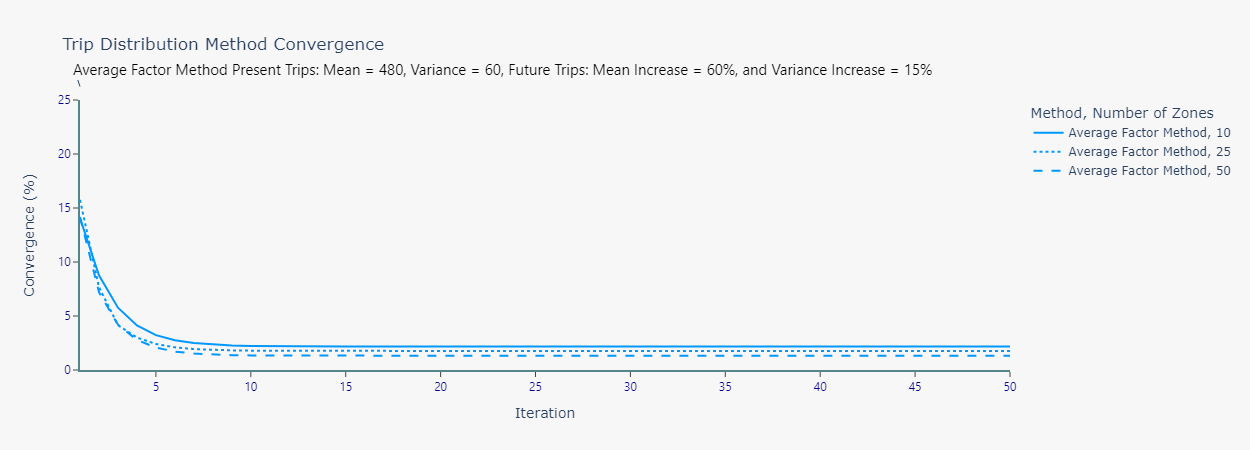

In [13]:
ded_test(dist_func='AFM', n_zones=[10, 25, 50], test_pre_mean=480, test_pre_var=60, factor_fut_mean=0.6, factor_fut_var=0.15, n_iter=50)

### <span style='font-family: Helvetica; font-size: 25px'>**V.A.ii. Detroit method**</span>

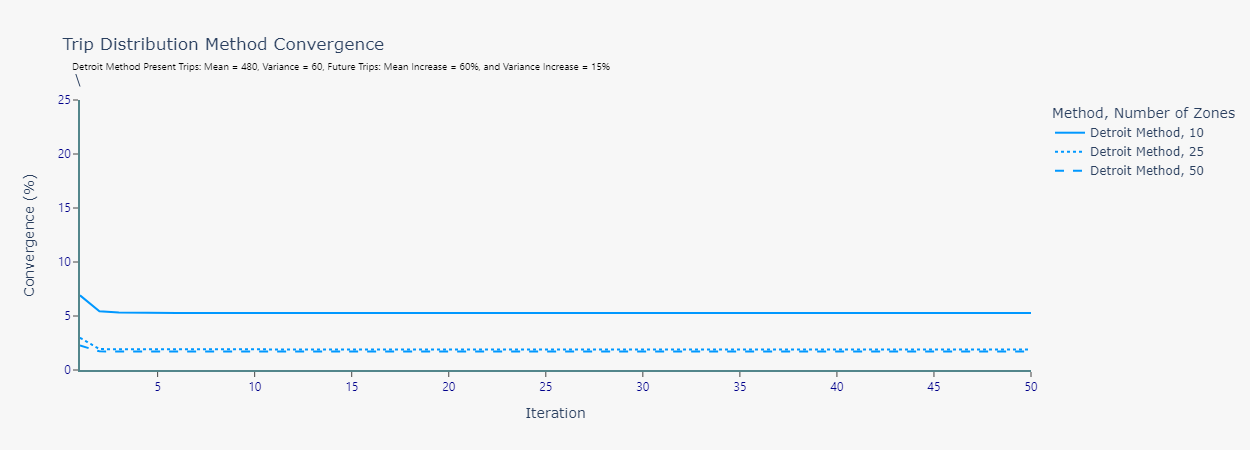

In [14]:
ded_test(dist_func='DM', n_zones=[10, 25, 50], test_pre_mean=480, test_pre_var=60, factor_fut_mean=0.6, factor_fut_var=0.15, n_iter=50)

### <span style='font-family: Helvetica; font-size: 25px'>**V.A.iii. Fratar method**</span>

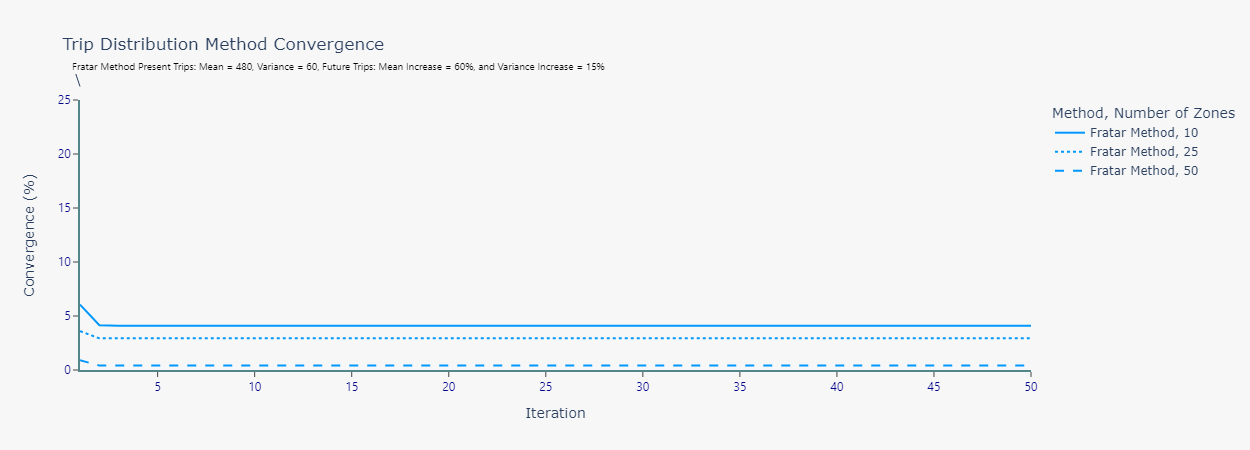

In [15]:
ded_test(dist_func='FM', n_zones=[10, 25, 50], test_pre_mean=480, test_pre_var=60, factor_fut_mean=0.6, factor_fut_var=0.15, n_iter=50)

### <span style='font-family: Helvetica; font-size: 25px'>**V.A.iv. Furness method**</span>

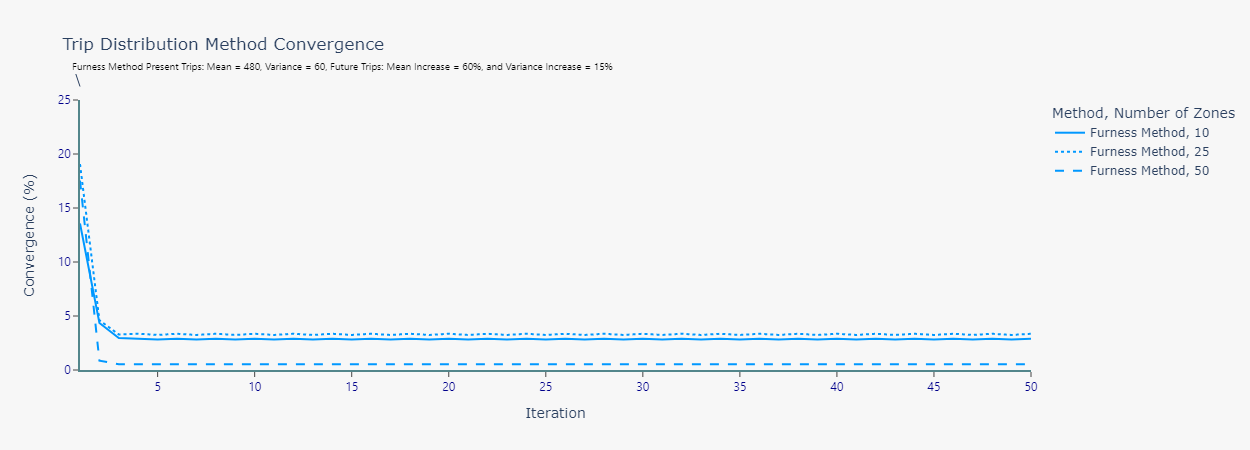

In [16]:
ded_test(dist_func='FurM', n_zones=[10, 25, 50], test_pre_mean=480, test_pre_var=60, factor_fut_mean=0.6, factor_fut_var=0.15, n_iter=50)

### <span style='font-family: Helvetica; font-size: 25px'>**V.A.v. Synthetic method (Impedance - Generation constrained)**</span>

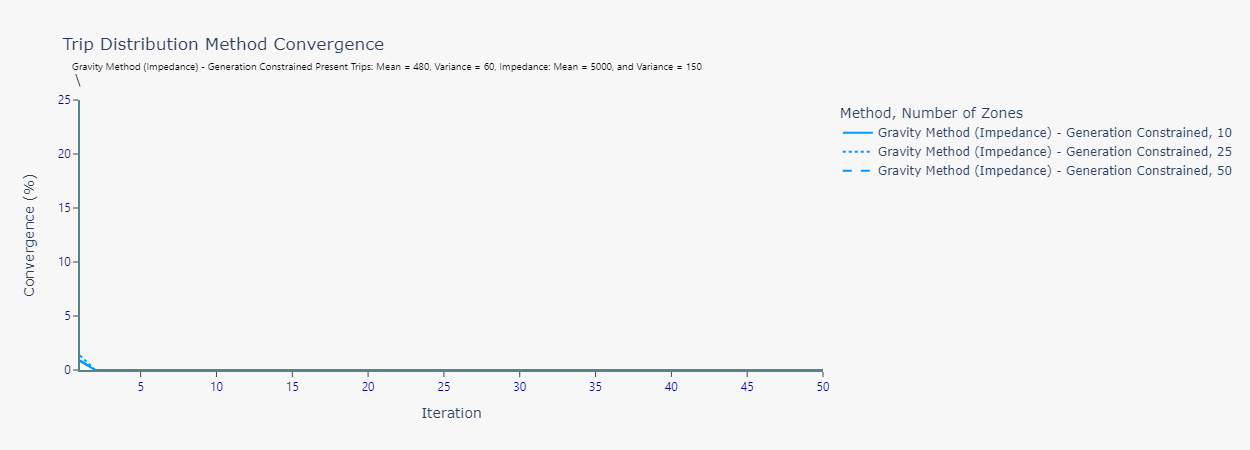

In [17]:
ded_test(dist_func='GMImp', n_zones=[10, 25, 50], test_pre_mean=480, test_pre_var=60, gm_imp_mean=5000, gm_imp_var=150, gm_type='GEN',n_iter=50)

### <span style='font-family: Helvetica; font-size: 25px'>**V.A.vi. Synthetic method (Impedance - Attraction constrained)**</span>

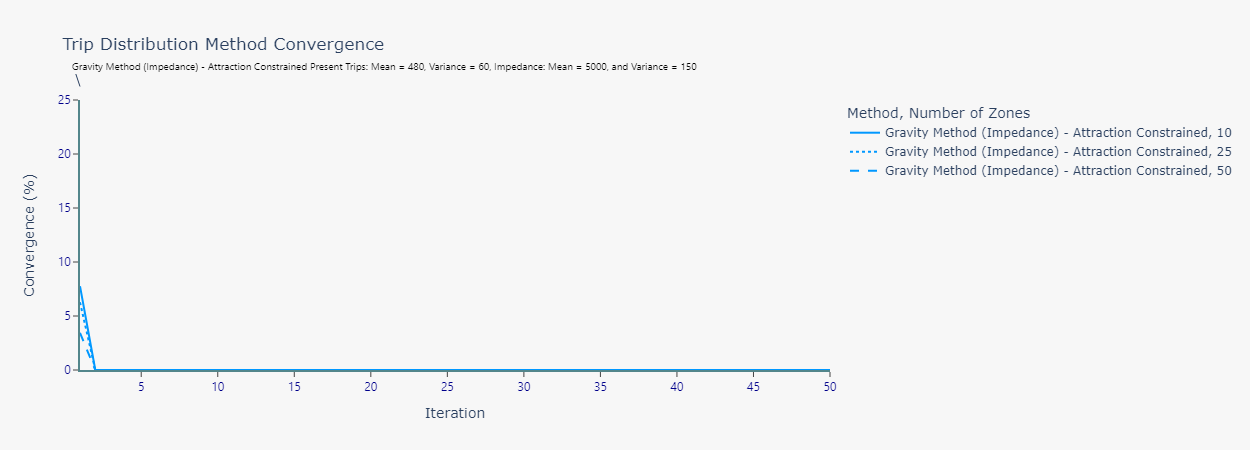

In [18]:
ded_test(dist_func='GMImp', n_zones=[10, 25, 50], test_pre_mean=480, test_pre_var=60, gm_imp_mean=5000, gm_imp_var=150, gm_type='ATT', n_iter=50)

### <span style='font-family: Helvetica; font-size: 25px'>**V.A.vii. Synthetic method (Deterrence - Exponential cost function)**</span>

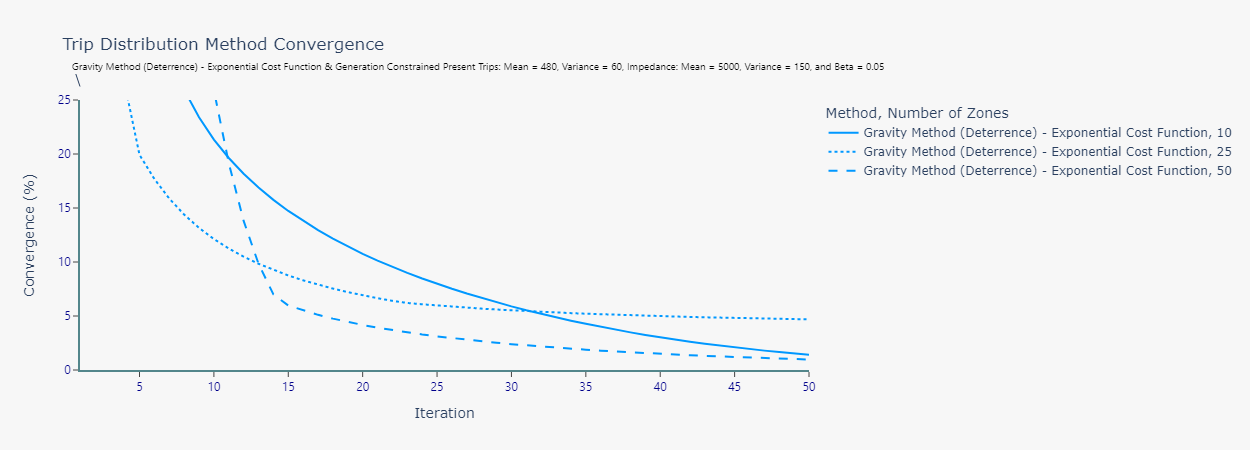

In [19]:
ded_test(dist_func='GMDet', n_zones=[10, 25, 50], test_pre_mean=480, test_pre_var=60, gm_det_func='Exponential',
       gm_det_mean=5000, gm_det_var=150, gm_det_beta=0.05, gm_type='GEN', n_iter=50)

### <span style='font-family: Helvetica; font-size: 25px'>**V.A.viii. Synthetic method (Deterrence - Power cost function)**</span>

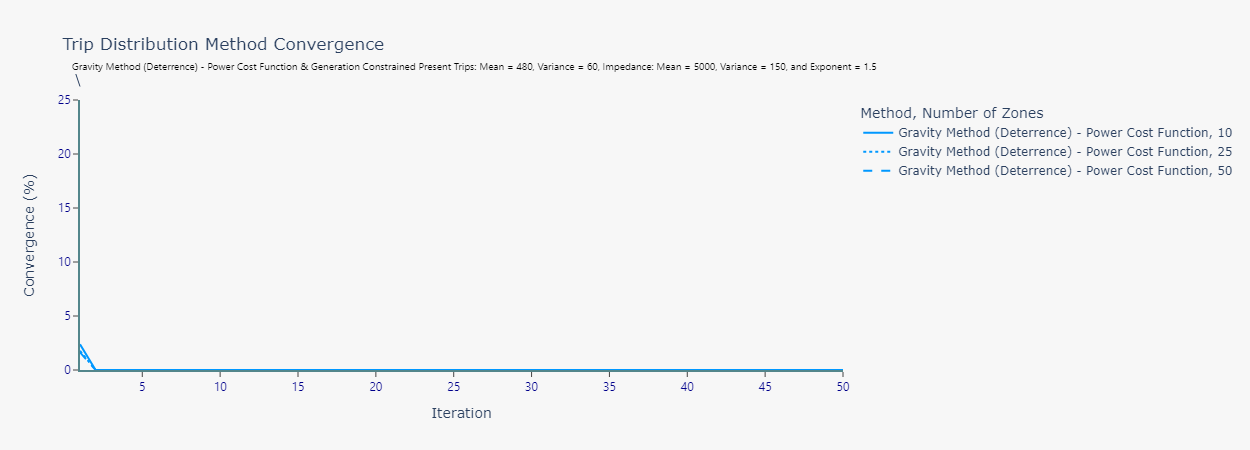

In [20]:
ded_test(dist_func='GMDet', n_zones=[10, 25, 50], test_pre_mean=480, test_pre_var=60, gm_det_func='Power',
       gm_det_mean=5000, gm_det_var=150, gm_det_exp=1.5, gm_type='GEN', n_iter=50)

### <span style='font-family: Helvetica; font-size: 25px'>**V.A.ix. Synthetic method (Deterrence - Combined cost function)**</span>

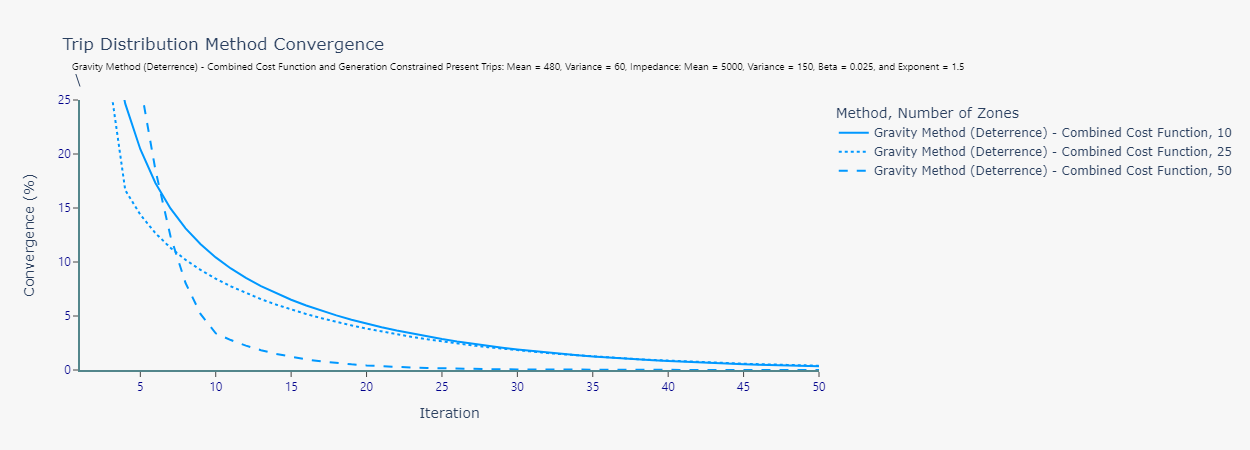

In [21]:
ded_test(dist_func='GMDet', n_zones=[10, 25, 50], test_pre_mean=480, test_pre_var=60, gm_det_func='Combined',
       gm_det_mean=5000, gm_det_var=150, gm_det_exp=1.5, gm_det_beta=0.025, gm_type='GEN', n_iter=50)

## <span style='font-family: Helvetica; font-size: 25px'>**V.B. Based on single PDF in creating trip matrices**</span>

In [ ]:
conv_test(dist_func_arr=['AFM', 'GMImp', 'GMDet', 'DM', 'FM'], n_zones=[5,10], test_pre_mean=480, test_pre_var=60,
          factor_fut_mean=0.6, factor_fut_var=0.15, n_iter=250,
          gm_imp_mean=5000, gm_imp_var=150, gm_type=['ATT', 'GEN'],
          gm_det_func=['Exponential', 'Combined'], gm_det_beta=0.1, gm_det_exp=1.25, gm_det_mean=5000, gm_det_var=150)

## <span style='font-family: Helvetica; font-size: 25px'>**V.C. Based on multiple probability distribution function**</span>

# <span style='font-family: Helvetica; font-size: 25px'>**VI. Summary**</span>

<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'>After implementing and comparing all nine methods, several key patterns emerged. Growth factor methods generally performed well in scenarios with consistent future production and attraction totals. The Average Factor and Furness methods ensured matrix balance but sometimes took longer to converge.<br><br><strong>Synthetic methods, particularly the Impedance – Generation Constrained and Deterrence – Power Cost Function approaches, were the fastest to converge.</strong> Their reliance on cost-based decay functions made them more adaptable in scenarios without historical matrices. The generation-constrained impedance method reached convergence in fewer iterations than any other, making it especially useful for rapid planning assessments.<br><br>While growth factor methods benefit from historical continuity, they can be limited when future totals are inconsistent with base patterns. Synthetic methods, on the other hand, allow flexibility, especially in data-scarce environments, though their accuracy depends heavily on the impedance matrix and parameter choices.

</p>
</div>

# <span style='font-family: Helvetica; font-size: 25px'>**VII. Conclusion**</span>

<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'>Trip distribution remains one of the most important components of travel demand modeling. This notebook explored both growth factor and synthetic methods in detail. Each method was examined through matrix logic, convergence evaluation, and discussion of advantages and limitations.<br><br><strong>Growth factor methods depend on available historical OD data and projected totals.</strong> These are suitable for regions with consistent travel patterns and long-term data availability. <strong>In contrast, synthetic methods offer a versatile, cost-based approach that can model trip interactions with limited prior data.</strong><br><br>The Impedance – Generation Constrained and Deterrence – Power Cost Function methods demonstrated the fastest convergence rates in this analysis, highlighting their computational efficiency. However, proper calibration and data quality remain crucial across all methods.<br><br><strong>By understanding the trade-offs and applications of each approach, planners and analysts can make informed decisions tailored to specific urban contexts and data environments.</strong></p>
</div>